#### PAIR PROGRAMMING - LIMPIEZA 3

In [43]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

pd.options.display.max_columns = None

Antes de seguir, recordamos las preguntas que nos planteamos al principio del pair programming para dirigir nuestro análisis.

In [44]:
df = pd.read_csv('datos/bank_additional_edit2.csv', index_col = 0)
df.head(3)

,age,job,marital,education,default,housing,loan,contact,duration,campaign,pdays,previous,poutcome,"emp,var,rate","cons,price,idx","cons,conf,idx",euribor3m,"nr,employed",y,month_day_week,month,day_week
0,56,housemaid,married,basic 4y,No,No,No,telephone,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,"['may', 'mon']",'may','mon'
1,57,services,married,high school,NaN,No,No,telephone,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,"['may', 'mon']",'may','mon'
2,37,services,married,high school,No,Si,No,telephone,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,"['may', 'mon']",'may','mon'


In [45]:
df.reset_index()
df.head()

,age,job,marital,education,default,housing,loan,contact,duration,campaign,pdays,previous,poutcome,"emp,var,rate","cons,price,idx","cons,conf,idx",euribor3m,"nr,employed",y,month_day_week,month,day_week
0,56,housemaid,married,basic 4y,No,No,No,telephone,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,"['may', 'mon']",'may','mon'
1,57,services,married,high school,NaN,No,No,telephone,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,"['may', 'mon']",'may','mon'
2,37,services,married,high school,No,Si,No,telephone,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,"['may', 'mon']",'may','mon'
3,40,administrative,married,basic 6y,No,No,No,telephone,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,"['may', 'mon']",'may','mon'
4,56,services,married,high school,No,No,Si,telephone,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,"['may', 'mon']",'may','mon'


#### HIPÓTESIS

1. La edad, el trabajo, el estado civil, la educación, la situación de deuda y la forma de contacto pueden influir en la probabilidad de que un cliente acepte la oferta.

2. El número de veces que se ha contactado a un cliente en el pasado (campo campaign), el número de días que han pasado desde el último contacto (campo pdays), y el resultado de la campaña anterior (campo poutcome) pueden afectar la respuesta del cliente a una nueva oferta.

3. Las variables económicas (tales como el índice de precios al consumidor (cons.price.idx), la tasa de variación del empleo (emp.var.rate), etc.) pueden influir en la probabilidad de que un cliente acepte la oferta.

4. Los clientes que ya tienen una hipoteca (housing) o un préstamo (loan) pueden ser menos propensos a aceptar una nueva oferta, ya que podrían estar limitados financieramente.

Ya hemos limpiado todas las columnas que parecía que no tenían el tipo de dato que queríamos o que tenían demasiada información. Por lo tanto, en este ejercicio tendremos que limpiar los outliers.

1. ¿Sobre qué columnas podremos eliminar o reemplazar los outliers?

In [46]:
df_numericas = df.select_dtypes(include = np.number)

In [47]:
df_numericas.head(3)

,age,duration,campaign,pdays,previous,"emp,var,rate","cons,price,idx","cons,conf,idx",euribor3m,"nr,employed"
0,56,261,1,999,0,1.1,93.994,-36.4,4.857,5191.0
1,57,149,1,999,0,1.1,93.994,-36.4,4.857,5191.0
2,37,226,1,999,0,1.1,93.994,-36.4,4.857,5191.0


In [48]:
df_numericas['previous'].unique() # nº de contactos realizados antes de la campaña

array([0, 1, 2, 3, 4, 5, 6, 7])

In [49]:
df_numericas['pdays'].unique() #nº de días desde el que se le contactó al cliente por última vez. Si hay 999: no se le ha contactado nunca antes

array([999,   6,   4,   3,   5,   1,   0,  10,   7,   8,   9,  11,   2,
        12,  13,  14,  15,  16,  21,  17,  18,  22,  25,  26,  19,  27,
        20])

2. Identifica visualmente los outliers

In [50]:
len(df_numericas.columns)

10

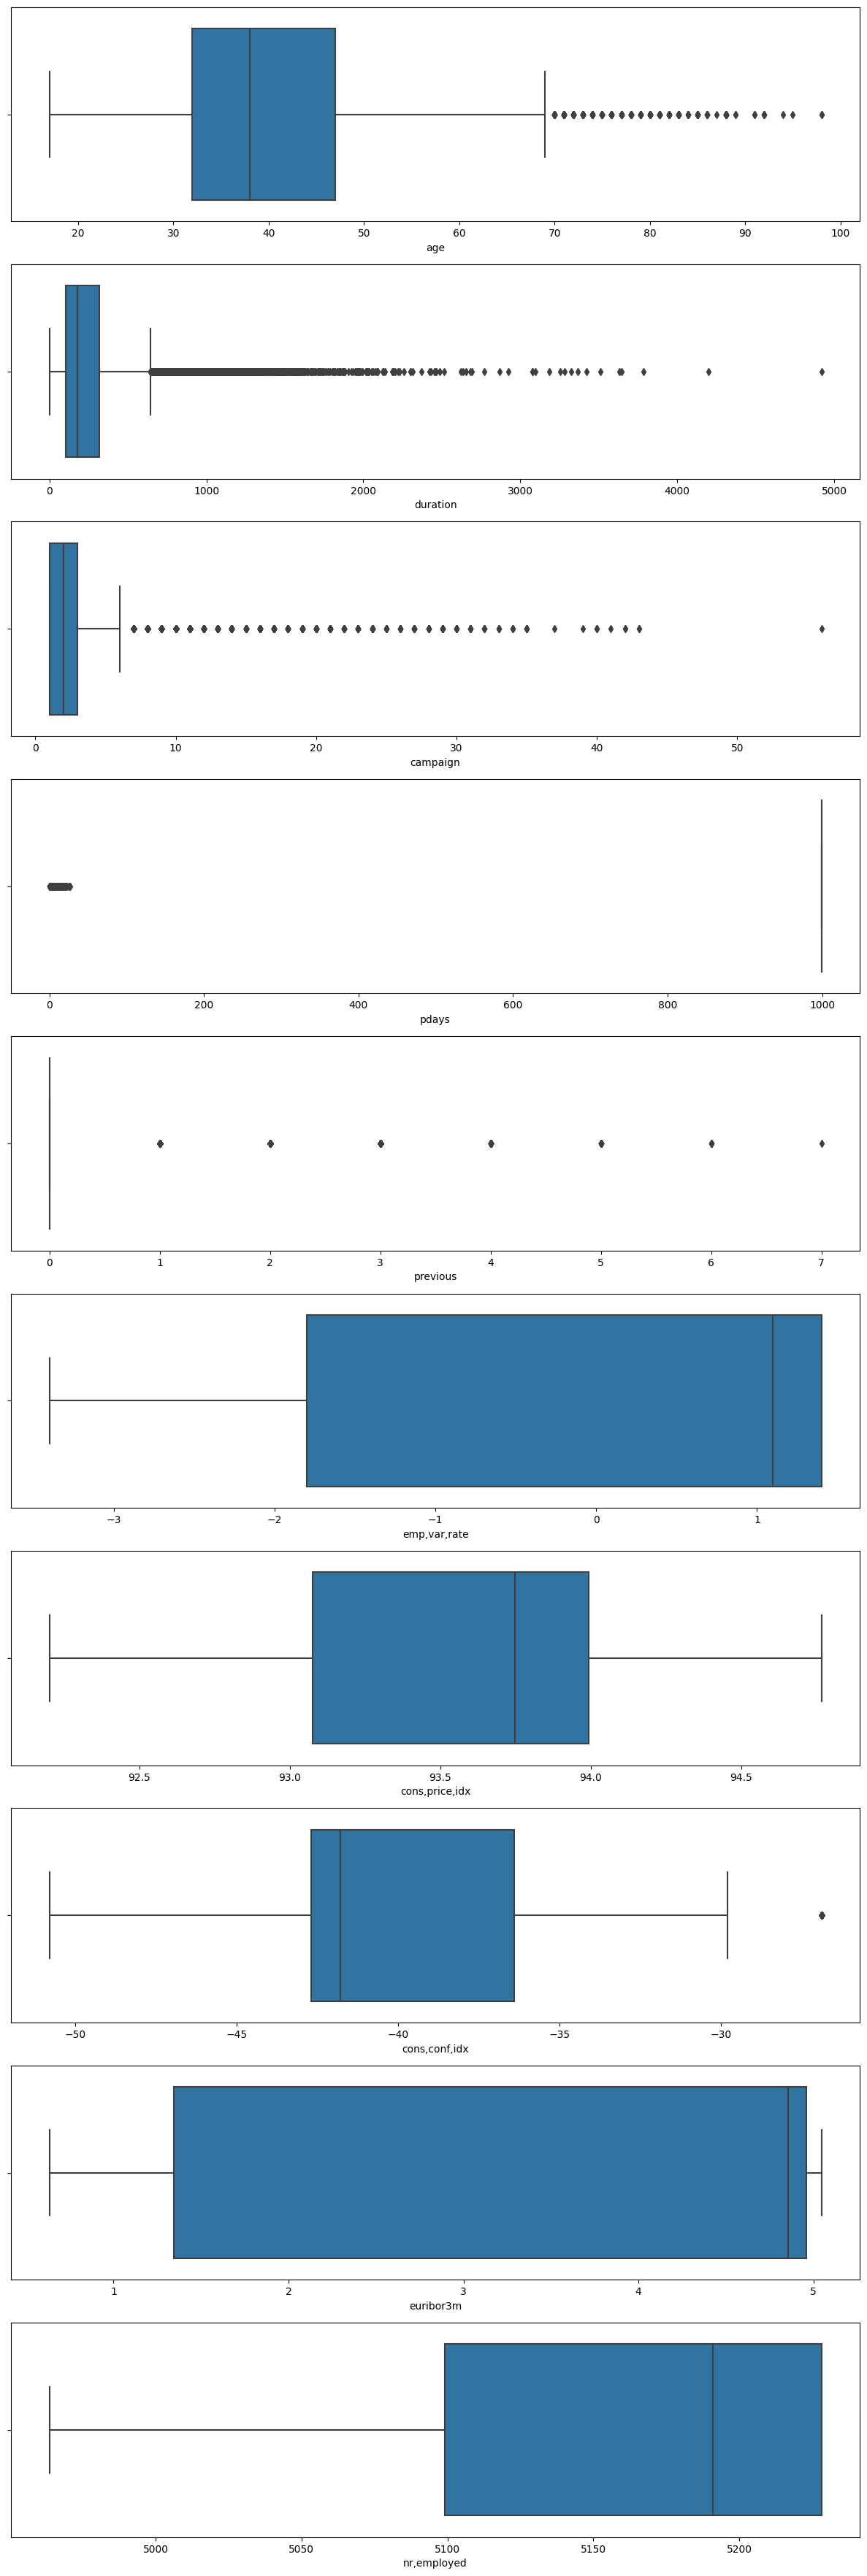

In [51]:
# tenemos 10 columnas, por lo que creamos 10 subplots
fig, ax = plt.subplots(10, 1, figsize=(15,45))

for i in range(len(df_numericas.columns)):
    sns.boxplot(x=df_numericas.columns[i], data=df_numericas, ax=ax[i])
plt.show();

3. Identifica sobre el dataframe las filas que son outliers

In [52]:
def detectar_outliers(lista_columnas, dataframe): 
    
    dicc_indices = {} # creamos un diccionario donde almacenaremos índices de los outliers
    
    # iteramos por la lista de las columnas numéricas de nuestro dataframe
    for col in lista_columnas:
        
        #calculamos los cuartiles Q1 y Q3
        Q1 = np.nanpercentile(df[col], 25)
        Q3 = np.nanpercentile(df[col], 75)
        
        # calculamos el rango intercuartil
        IQR = Q3 - Q1
        
        # calculamos los límites
        outlier_step = 1.5 * IQR
        
        # filtramos nuestro dataframe para indentificar los outliers
        outliers_data = dataframe[(dataframe[col] < Q1 - outlier_step) | (dataframe[col] > Q3 + outlier_step)]
        
        
        if outliers_data.shape[0] > 0: # chequeamos si nuestro dataframe tiene alguna fila. 
        
            dicc_indices[col] = (list(outliers_data.index)) # si tiene fila es que hay outliers y por lo tanto lo añadimos a nuestro diccionario
        

    
    return dicc_indices

In [53]:
lista_columnas = list(df_numericas.columns)
lista_columnas

['age',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'emp,var,rate',
 'cons,price,idx',
 'cons,conf,idx',
 'euribor3m',
 'nr,employed']

In [54]:
ind = detectar_outliers(lista_columnas, df)
indices = ind.values()
indices

dict_values([[27713, 27757, 27780, 27800, 27802, 27805, 27808, 27810, 27811, 27812, 27813, 27814, 27815, 27816, 27817, 27818, 27826, 27837, 27838, 27844, 27851, 27875, 27879, 27902, 27930, 27950, 27951, 27963, 28220, 28221, 28312, 28456, 28504, 28530, 28540, 28586, 28619, 28732, 28773, 29225, 29263, 29498, 29625, 29668, 29682, 29973, 29977, 29981, 29987, 29990, 30000, 30004, 30006, 30072, 30078, 30079, 30088, 30103, 30110, 30133, 30171, 30214, 30225, 30227, 30241, 30334, 30335, 30390, 30430, 30460, 30589, 35833, 35848, 35856, 35878, 35973, 36183, 36285, 36311, 36383, 36384, 36816, 36998, 37136, 37137, 37170, 37186, 37190, 37192, 37193, 37195, 37206, 37207, 37213, 37219, 37227, 37235, 37237, 37239, 37257, 37260, 37316, 37341, 37355, 37371, 37403, 37454, 37455, 37472, 37479, 37493, 37505, 37509, 37512, 37525, 37532, 37545, 37568, 37570, 37586, 37597, 37601, 37602, 37604, 37635, 37661, 37675, 37679, 37690, 37692, 37715, 37716, 37735, 37736, 37743, 37756, 37765, 37769, 37775, 37784, 37818,

In [55]:
indices1 = {indice for sublista in indices for indice in sublista}
lista_idx = list(indices1)
lista_idx

[32768,
 32771,
 32777,
 32782,
 32784,
 32785,
 32789,
 32790,
 32792,
 32797,
 32798,
 32801,
 32804,
 37,
 32807,
 32809,
 32811,
 32815,
 32817,
 32820,
 32824,
 57,
 32825,
 32827,
 61,
 32830,
 32829,
 32831,
 32832,
 32836,
 32837,
 32839,
 32841,
 75,
 32843,
 32845,
 32846,
 32847,
 32848,
 83,
 32852,
 88,
 32861,
 32864,
 32865,
 32866,
 32868,
 32872,
 32874,
 32875,
 32878,
 111,
 32881,
 32882,
 32884,
 32889,
 32891,
 32893,
 32895,
 131,
 32899,
 32900,
 32904,
 32907,
 32913,
 32914,
 32915,
 32919,
 32925,
 32928,
 32929,
 32930,
 32931,
 164,
 32932,
 169,
 32937,
 32939,
 32949,
 182,
 32951,
 32952,
 32954,
 32956,
 32960,
 195,
 32965,
 198,
 199,
 32968,
 32975,
 32982,
 32983,
 32985,
 32987,
 32988,
 32989,
 32992,
 32994,
 32996,
 33000,
 33001,
 33003,
 33006,
 33009,
 243,
 33016,
 249,
 33019,
 33020,
 33022,
 33026,
 33028,
 33029,
 33030,
 33031,
 33032,
 33035,
 33037,
 33038,
 33042,
 276,
 33046,
 33047,
 33049,
 33050,
 33051,
 286,
 33056,
 33059,
 3

In [56]:
# df.reset_index(inplace= True)
# df.head(2)

In [57]:
df.head()

,age,job,marital,education,default,housing,loan,contact,duration,campaign,pdays,previous,poutcome,"emp,var,rate","cons,price,idx","cons,conf,idx",euribor3m,"nr,employed",y,month_day_week,month,day_week
0,56,housemaid,married,basic 4y,No,No,No,telephone,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,"['may', 'mon']",'may','mon'
1,57,services,married,high school,NaN,No,No,telephone,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,"['may', 'mon']",'may','mon'
2,37,services,married,high school,No,Si,No,telephone,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,"['may', 'mon']",'may','mon'
3,40,administrative,married,basic 6y,No,No,No,telephone,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,"['may', 'mon']",'may','mon'
4,56,services,married,high school,No,No,Si,telephone,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,"['may', 'mon']",'may','mon'


In [58]:
ind.values()

dict_values([[27713, 27757, 27780, 27800, 27802, 27805, 27808, 27810, 27811, 27812, 27813, 27814, 27815, 27816, 27817, 27818, 27826, 27837, 27838, 27844, 27851, 27875, 27879, 27902, 27930, 27950, 27951, 27963, 28220, 28221, 28312, 28456, 28504, 28530, 28540, 28586, 28619, 28732, 28773, 29225, 29263, 29498, 29625, 29668, 29682, 29973, 29977, 29981, 29987, 29990, 30000, 30004, 30006, 30072, 30078, 30079, 30088, 30103, 30110, 30133, 30171, 30214, 30225, 30227, 30241, 30334, 30335, 30390, 30430, 30460, 30589, 35833, 35848, 35856, 35878, 35973, 36183, 36285, 36311, 36383, 36384, 36816, 36998, 37136, 37137, 37170, 37186, 37190, 37192, 37193, 37195, 37206, 37207, 37213, 37219, 37227, 37235, 37237, 37239, 37257, 37260, 37316, 37341, 37355, 37371, 37403, 37454, 37455, 37472, 37479, 37493, 37505, 37509, 37512, 37525, 37532, 37545, 37568, 37570, 37586, 37597, 37601, 37602, 37604, 37635, 37661, 37675, 37679, 37690, 37692, 37715, 37716, 37735, 37736, 37743, 37756, 37765, 37769, 37775, 37784, 37818,

In [59]:
df.reset_index(inplace= True)

In [60]:
df_outliers = df[df['index'].isin(lista_idx)] #necesitamos lista, pero hay que aplanarlos para obtener lista, ya que originariamente dico

In [61]:
df_outliers.head(3)

,index,age,job,marital,education,default,housing,loan,contact,duration,campaign,pdays,previous,poutcome,"emp,var,rate","cons,price,idx","cons,conf,idx",euribor3m,"nr,employed",y,month_day_week,month,day_week
37,37,52,technician,married,basic 9y,No,Si,No,telephone,1666,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,"['may', 'mon']",'may','mon'
57,57,45,services,married,high school,NaN,Si,No,telephone,787,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,"['may', 'mon']",'may','mon'
61,61,51,blue-collar,married,basic 9y,No,Si,No,telephone,812,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,"['may', 'mon']",'may','mon'


In [62]:
# df_dico = pd.DataFrame([[key, ind[key]] for key in ind.keys()], columns=['x', 'y'])
# df_dico #no es esto lo que queremos 

4. Reemplaza los outliers por el estadístico más correcto.

In [63]:
for k, v in ind.items():
    mediana = df[k].median() # calculamos la media para cada una de las columnas que tenemos en nuestro diccionario
    for i in v: # iteremos por la lista de valores para cada columna
        df.loc[i,k] = mediana 

In [64]:
df.head(40)

,index,age,job,marital,education,default,housing,loan,contact,duration,campaign,pdays,previous,poutcome,"emp,var,rate","cons,price,idx","cons,conf,idx",euribor3m,"nr,employed",y,month_day_week,month,day_week
0,0.0,56.0,housemaid,married,basic 4y,No,No,No,telephone,261.0,1.0,999.0,0.0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,"['may', 'mon']",'may','mon'
1,1.0,57.0,services,married,high school,NaN,No,No,telephone,149.0,1.0,999.0,0.0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,"['may', 'mon']",'may','mon'
2,2.0,37.0,services,married,high school,No,Si,No,telephone,226.0,1.0,999.0,0.0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,"['may', 'mon']",'may','mon'
3,3.0,40.0,administrative,married,basic 6y,No,No,No,telephone,151.0,1.0,999.0,0.0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,"['may', 'mon']",'may','mon'
4,4.0,56.0,services,married,high school,No,No,Si,telephone,307.0,1.0,999.0,0.0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,"['may', 'mon']",'may','mon'
5,5.0,45.0,services,married,basic 9y,NaN,No,No,telephone,198.0,1.0,999.0,0.0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,"['may', 'mon']",'may','mon'
6,6.0,59.0,administrative,married,professional course,No,No,No,telephone,139.0,1.0,999.0,0.0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,"['may', 'mon']",'may','mon'
7,7.0,41.0,blue-collar,married,NaN,NaN,No,No,telephone,217.0,1.0,999.0,0.0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,"['may', 'mon']",'may','mon'
8,8.0,24.0,technician,single,professional course,No,Si,No,telephone,380.0,1.0,999.0,0.0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,"['may', 'mon']",'may','mon'
9,9.0,25.0,services,single,high school,No,Si,No,telephone,50.0,1.0,999.0,0.0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,"['may', 'mon']",'may','mon'


In [65]:
#¿cómo vemos que se han reemplazado?

5. Guarda el csv con las columnas limpias para seguir trabajando con este dataframe limpio en el siguiente pair programming de limpieza.

In [66]:
df.to_csv('datos/bank_additional_edit3.csv')